In [1]:
%%bash

# Check if Model 4 venv exists
MODEL4_VENV="/Users/gurudev/Desktop/VS Code/MyProjects/AIML/model4-cnn-bilstm-attention/.venv"
CURRENT_DIR="/Users/gurudev/Desktop/VS Code/MyProjects/AIML/model2-cnn-lstm-attention"

if [ -d "$MODEL4_VENV" ]; then
    echo "✅ Found Model 4 virtual environment"
    echo "📦 Checking for required packages..."
    
    # Activate Model 4 venv
    source "$MODEL4_VENV/bin/activate"
    
    # Check for required packages
    MISSING_PACKAGES=()
    
    for package in torch numpy pandas matplotlib scikit-learn seaborn; do
        if ! python -c "import $package" 2>/dev/null; then
            MISSING_PACKAGES+=("$package")
        fi
    done
    
    if [ ${#MISSING_PACKAGES[@]} -eq 0 ]; then
        echo "✅ All required packages found in Model 4 venv"
        echo "🔗 Creating symlink to Model 4 venv..."
        cd "$CURRENT_DIR"
        ln -sf "$MODEL4_VENV" .venv
        echo "✅ Setup complete! Using Model 4's virtual environment"
    else
        echo "⚠️  Missing packages: ${MISSING_PACKAGES[*]}"
        echo "📦 Installing missing packages..."
        uv pip install ${MISSING_PACKAGES[*]}
        cd "$CURRENT_DIR"
        ln -sf "$MODEL4_VENV" .venv
        echo "✅ Packages installed! Using Model 4's virtual environment"
    fi
else
    echo "❌ Model 4 venv not found"
    echo "🌍 Creating new virtual environment with uv..."
    cd "$CURRENT_DIR"
    uv venv .venv --python 3.11
    source .venv/bin/activate
    
    echo "📦 Installing dependencies..."
    uv pip install torch torchvision torchaudio
    uv pip install numpy pandas matplotlib scikit-learn seaborn
    
    echo "✅ Virtual environment created successfully!"
fi

echo ""
echo "🐍 Python location: $(which python)"
echo "📍 Venv location: $(cd "$CURRENT_DIR" && pwd)/.venv"

✅ Found Model 4 virtual environment
📦 Checking for required packages...
⚠️  Missing packages: matplotlib scikit-learn seaborn
📦 Installing missing packages...
⚠️  Missing packages: matplotlib scikit-learn seaborn
📦 Installing missing packages...


Using Python 3.11.14 environment at: /Users/gurudev/Desktop/VS Code/MyProjects/AIML/model4-cnn-bilstm-attention/.venv
ilstm-attention/.venv
Audited 3 packages in 16ms
Audited 3 packages in 16ms


✅ Packages installed! Using Model 4's virtual environment

🐍 Python location: /Users/gurudev/Desktop/VS Code/MyProjects/AIML/model4-cnn-bilstm-attention/.venv/bin/python
📍 Venv location: /Users/gurudev/Desktop/VS Code/MyProjects/AIML/model2-cnn-lstm-attention/.venv

🐍 Python location: /Users/gurudev/Desktop/VS Code/MyProjects/AIML/model4-cnn-bilstm-attention/.venv/bin/python
📍 Venv location: /Users/gurudev/Desktop/VS Code/MyProjects/AIML/model2-cnn-lstm-attention/.venv


## Step 0: Setup Virtual Environment

First, check if Model 4's virtual environment exists and use it, otherwise create a new one.

# Model 2: CNN-LSTM-Attention Training

This notebook trains the CNN-LSTM with Attention model on UCI-HAR dataset.

**Model Architecture:**
- Conv1D layers for feature extraction
- LSTM for temporal modeling
- Temporal attention mechanism
- Fully connected layer for classification

**Expected Performance:** ~92-94% accuracy (2-3% improvement over baseline)

## Step 1: Environment Setup

In [2]:
import sys
import os

# Use the virtual environment
venv_path = os.path.abspath('.venv')
python_version = f"{sys.version_info.major}.{sys.version_info.minor}"
site_packages = f"{venv_path}/lib/python{python_version}/site-packages"

if site_packages not in sys.path:
    sys.path.insert(0, site_packages)

# Now import packages
import torch
import torch.nn as nn
import numpy as np

# Check device availability
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('✅ Training on Apple Silicon GPU (MPS)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('✅ Training on CUDA GPU')
else:
    device = torch.device('cpu')
    print('⚠️  Training on CPU')

print(f'🔥 PyTorch version: {torch.__version__}')
print(f'💻 Device: {device}')

✅ Training on Apple Silicon GPU (MPS)
🔥 PyTorch version: 2.9.1
💻 Device: mps


## Step 2: Load UCI-HAR Dataset

In [4]:
# Import data preprocessing (force reimport to get latest changes)
import sys
sys.path.append('.')

# Clear any cached imports
if 'dataset' in sys.modules:
    del sys.modules['dataset']
if 'data_preprocess' in sys.modules:
    del sys.modules['data_preprocess']

from dataset import load_data

# Load dataset
X_train, y_train, X_test, y_test = load_data()

print(f"📊 Dataset loaded successfully!")
print(f"   Training samples: {X_train.shape}")
print(f"   Test samples: {X_test.shape}")
print(f"   Training labels: {y_train.shape}")
print(f"   Test labels: {y_test.shape}")
print(f"\n   Timesteps: {X_train.shape[1]}")
print(f"   Input features: {X_train.shape[2]}")
print(f"   Number of classes: {len(np.unique(y_train))}")

1 (7352, 1152)
1 (7352, 128, 9)
1 (2947, 1152)
1 (2947, 128, 9)
/Users/gurudev/Desktop/VS Code/MyProjects/AIML/human+activity+recognition+using+smartphones/UCI HAR Dataset/
📊 Dataset loaded successfully!
   Training samples: (7352, 128, 9)
   Test samples: (2947, 128, 9)
   Training labels: (7352,)
   Test labels: (2947,)

   Timesteps: 128
   Input features: 9
   Number of classes: 6
1 (2947, 1152)
1 (2947, 128, 9)
/Users/gurudev/Desktop/VS Code/MyProjects/AIML/human+activity+recognition+using+smartphones/UCI HAR Dataset/
📊 Dataset loaded successfully!
   Training samples: (7352, 128, 9)
   Test samples: (2947, 128, 9)
   Training labels: (7352,)
   Test labels: (2947,)

   Timesteps: 128
   Input features: 9
   Number of classes: 6


## Step 3: Define CNN-LSTM-Attention Model

In [5]:
from network import Network
from attention import TemporalAttn

# Create model with attention (Network class has hardcoded hyperparameters)
# Architecture: Conv1D(9->64) -> Conv1D(64->128) -> LSTM(32->128) -> Attention -> FC(128->6)
model = Network().to(device)

print("🏗️  Model Architecture (with Attention):")
print(model)
print(f"\n📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("\n💡 Model Configuration:")
print("   Input channels: 9 (accelerometer + gyroscope)")
print("   Conv1: 9 -> 64 channels, kernel=6")
print("   Conv2: 64 -> 128 channels, kernel=3")
print("   LSTM: input_size=32, hidden_size=128, layers=1")
print("   Attention: TemporalAttn(hidden_size=128)")
print("   FC: 128 -> 6 classes")
print("   Dropout: 0.1")

🏗️  Model Architecture (with Attention):
Network(
  (conv1): Sequential(
    (0): Conv1d(9, 64, kernel_size=(6,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(32, 128)
  (tanh): Tanh()
  (attn): TemporalAttn(
    (fc1): Linear(in_features=128, out_features=128, bias=False)
    (fc2): Linear(in_features=256, out_features=128, bias=False)
  )
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (softmax): Softmax(dim=1)
)

📊 Total parameters: 161,094

💡 Model Configuration:
   Input channels: 9 (accelerometer + gyroscope)
   Conv1: 9 -> 64 channels, kernel=6
   Conv2: 64 -> 128 channels, kernel=3
   

## Step 4: Training Configuration

In [6]:
# Training hyperparameters
learning_rate = 0.001
epochs = 50
batch_size = 64
clip_val = 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("⚙️  Training Configuration:")
print(f"   Learning rate: {learning_rate}")
print(f"   Epochs: {epochs}")
print(f"   Batch size: {batch_size}")
print(f"   Gradient clipping: {clip_val}")

⚙️  Training Configuration:
   Learning rate: 0.001
   Epochs: 50
   Batch size: 64
   Gradient clipping: 5


## Step 5: Train Model

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Prepare data loaders
train_data = TensorDataset(torch.from_numpy(X_train).float(), 
                           torch.from_numpy(y_train).long())
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(torch.from_numpy(X_test).float(), 
                          torch.from_numpy(y_test).long())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Training loop
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
best_accuracy = 0.0

print("\n🚀 Starting training...\n")

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze()
        
        # Permute input: (batch, timesteps, features) -> (batch, features, timesteps)
        # Conv1D expects (batch, channels, length)
        inputs = inputs.permute(0, 2, 1)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        optimizer.step()
        
        # Statistics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    # Calculate metrics
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation every 5 epochs
    if epoch % 5 == 0:
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.squeeze()
                
                # Permute input for Conv1D
                inputs = inputs.permute(0, 2, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)
        
        # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), 'best_model_cnn_lstm_attention.pth')
        
        print(f"Epoch {epoch}/{epochs}... "
              f"Train Loss: {avg_train_loss:.4f} Train Acc: {train_accuracy:.2f}% | "
              f"Test Loss: {avg_test_loss:.4f} Test Acc: {test_accuracy:.2f}%")
    else:
        print(f"Epoch {epoch}/{epochs}... "
              f"Train Loss: {avg_train_loss:.4f} Train Acc: {train_accuracy:.2f}%")

print(f"\n✅ Training complete!")
print(f"🏆 Best test accuracy: {best_accuracy:.2f}%")


🚀 Starting training...

Epoch 1/50... Train Loss: 1.5227 Train Acc: 50.73%
Epoch 1/50... Train Loss: 1.5227 Train Acc: 50.73%
Epoch 2/50... Train Loss: 1.3587 Train Acc: 68.92%
Epoch 2/50... Train Loss: 1.3587 Train Acc: 68.92%
Epoch 3/50... Train Loss: 1.2255 Train Acc: 83.39%
Epoch 3/50... Train Loss: 1.2255 Train Acc: 83.39%
Epoch 4/50... Train Loss: 1.1520 Train Acc: 89.83%
Epoch 4/50... Train Loss: 1.1520 Train Acc: 89.83%
Epoch 5/50... Train Loss: 1.1348 Train Acc: 91.54% | Test Loss: 1.1767 Test Acc: 87.24%
Epoch 5/50... Train Loss: 1.1348 Train Acc: 91.54% | Test Loss: 1.1767 Test Acc: 87.24%
Epoch 6/50... Train Loss: 1.1178 Train Acc: 92.91%
Epoch 6/50... Train Loss: 1.1178 Train Acc: 92.91%
Epoch 7/50... Train Loss: 1.1088 Train Acc: 93.93%
Epoch 7/50... Train Loss: 1.1088 Train Acc: 93.93%
Epoch 8/50... Train Loss: 1.1038 Train Acc: 94.45%
Epoch 8/50... Train Loss: 1.1038 Train Acc: 94.45%
Epoch 9/50... Train Loss: 1.1020 Train Acc: 94.48%
Epoch 9/50... Train Loss: 1.1020 T

## Step 6: Evaluate Final Model

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model
model.load_state_dict(torch.load('best_model_cnn_lstm_attention.pth'))
model.eval()

# Get predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze()
        
        # Permute input for Conv1D
        inputs = inputs.permute(0, 2, 1)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
f1 = f1_score(all_labels, all_preds, average='macro')
print(f"\n📊 Final Results:")
print(f"   Test Accuracy: {best_accuracy:.2f}%")
print(f"   F1 Score: {f1:.4f}")

# Activity labels
activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 
                   'SITTING', 'STANDING', 'LAYING']

print("\n📋 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=activity_labels))


📊 Final Results:
   Test Accuracy: 90.94%
   F1 Score: 0.9104

📋 Classification Report:
                    precision    recall  f1-score   support

           WALKING       0.87      0.98      0.92       496
  WALKING_UPSTAIRS       0.93      0.93      0.93       471
WALKING_DOWNSTAIRS       1.00      0.96      0.98       420
           SITTING       0.81      0.84      0.82       491
          STANDING       0.87      0.77      0.81       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.91      2947



## Step 7: Visualize Results

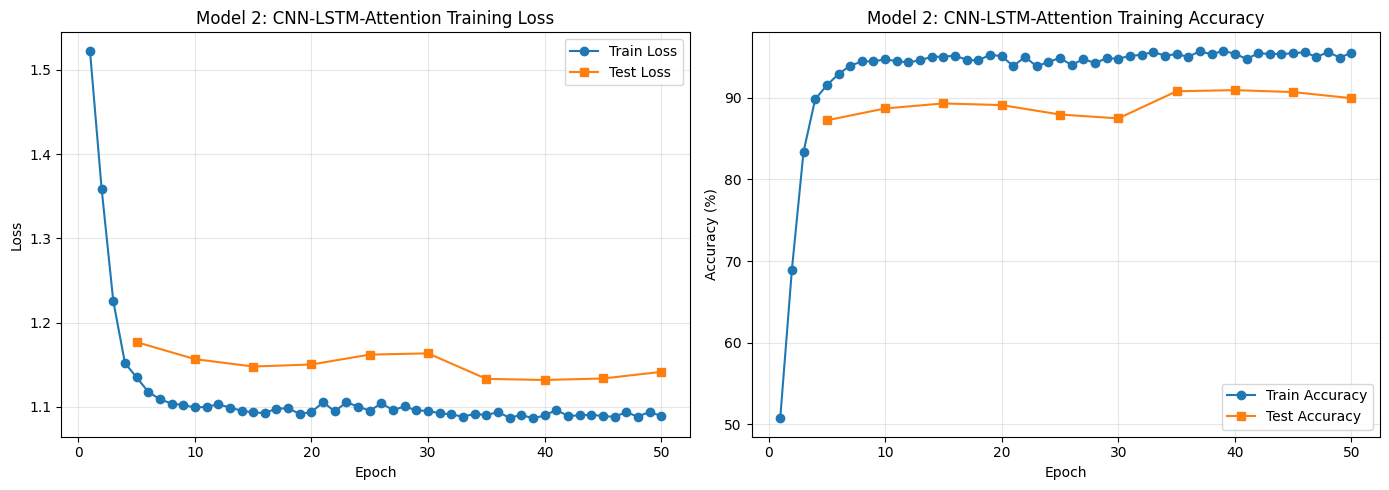

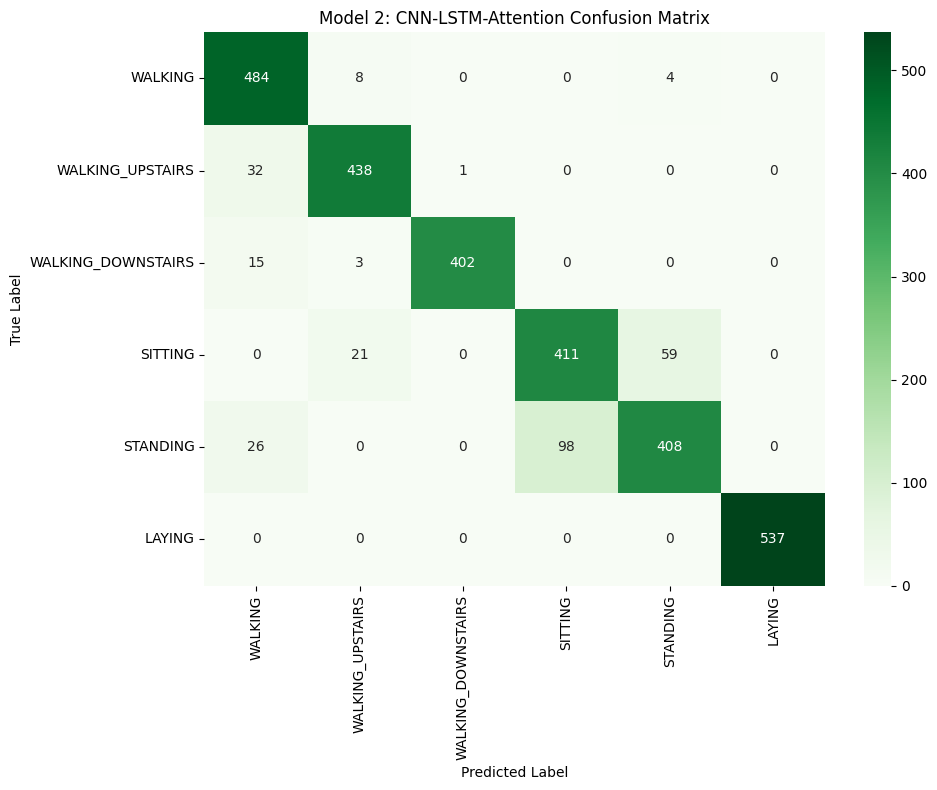


💾 Results saved:
   - best_model_cnn_lstm_attention.pth
   - model2_training_curves.png
   - model2_confusion_matrix.png


In [9]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
test_epochs = [i * 5 for i in range(1, len(test_losses) + 1)]
ax1.plot(test_epochs, test_losses, label='Test Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model 2: CNN-LSTM-Attention Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(test_epochs, test_accuracies, label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Model 2: CNN-LSTM-Attention Training Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=activity_labels, yticklabels=activity_labels)
plt.title('Model 2: CNN-LSTM-Attention Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('model2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Results saved:")
print("   - best_model_cnn_lstm_attention.pth")
print("   - model2_training_curves.png")
print("   - model2_confusion_matrix.png")

## Summary

✅ **Model 2 (CNN-LSTM-Attention) Training Complete!**

The attention mechanism allows the model to focus on important timesteps, typically improving performance by 2-3% compared to the baseline CNN-LSTM.